In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import os
import math
import time
import numpy as np
import scipy
import ghalton
import dicom
from scipy.interpolate import interp1d

In [2]:
'''
Helper function that cleans up list_directory
removes hidden files
'''
def clean(lis):
    try:
         
        lis.remove('.DS_Store')
    except:
        lis = lis
    return lis

'''
Helper function that retrieves all data files
cleans up the directory to leave only .dat files
'''
def get_files(lis):
    try:
        for i in list(lis):
            if('.dat' not in i):
                lis.remove(i)
    except:
        lis = lis
    return lis

##Bilinear Interpolation##

We need to find unknown pixel value at the new point $(x,y)$, and we know the pixel values at points 
$Q_{11} = (x_1,y_1), Q_{12} = (x_1, y_2), Q_{22} = (x_2, y_2), Q_{21} = (x_2, y_1).$ To do bilinear interpolation, we need to perform linear interpolation along the x-axis and y-axis. First we use the four know points to do linear interpolation along the x-axis, and we need to define two helper points  $R_1 = (x,y_1)$, and $R_2 = (x,y_2)$. We have

$$f(R_1) = \frac{x_2-x}{x_2-x_1} f(Q_{11}) + \frac{x-x_1}{x_2-x_1} f(Q_{21}) $$

$$f(R_2) = \frac{x_2-x}{x_2-x_1} f(Q_{12}) + \frac{x-x_1}{x_2-x_1} f(Q_{21}) $$

Now we can do linear interpolation along the y-axis with $R_1$ and $R_2$, which gives us,

$$f(P) = \frac{y_2-y}{y_2-y_1} f(R_1) + \frac{y-y_1}{y_2-y_1} f(R_2)$$

Let's denote $a = x_2-x, b = x-x_1, c=y-y_1, d=y_2-y,$ then we have the final interpolation result,

$$\begin{align}
f(P) &= \frac{ad}{(c+d)(a+b)} f(Q_{11}) + \frac{bd}{(c+d)(a+b)}f(Q_{21}) + \frac{ac}{(c+d)(a+b)} f(Q_{12}) + \frac{bc}{(c+d)(a+b)}f(Q_{22})\\
&= \frac{1}{(c+d)(a+b)}(ad\cdot f(Q_{11})+bd\cdot f(Q_{21})+ac\cdot f(Q_{12})+bc\cdot f(Q_{22}))
\end{align}$$

In this case, the known pixels are located on integer grid, so $a+b=c+d=1$, and that gives,

$$f(P) = ad\cdot f(Q_{11})+bd\cdot f(Q_{21})+ac\cdot f(Q_{12})+bc\cdot f(Q_{22})$$

<img src = "./bilinear2.png" height="350" width="350">

In [3]:
def bilinear_interp(image, x, y):

    x = np.asarray(x)
    y = np.asarray(y)

    # find the closes grid of the target points
    x1 = np.floor(x).astype(int)

    # Take care of boundary conditions
    # check if the input grid x, y is already on the original grid (i.e. special rotations)
    if (np.allclose(x.astype(int),x1)):
        return image[y.astype(int),x.astype(int)]
    
    x2 = x1 + 1
    y1 = np.floor(y).astype(int)
    y2 = y1 + 1
    
    # we need to clip the range 
    x1 = np.clip(x1, 0, image.shape[1]-1)
    x2 = np.clip(x2, 0, image.shape[1]-1)
    y1 = np.clip(y1, 0, image.shape[0]-1)
    y2 = np.clip(y2, 0, image.shape[0]-1)


    # get the four know points
    Q11 = image[y1, x1]
    Q21 = image[y1, x2]
    Q12 = image[y2, x1]
    Q22 = image[y2, x2]

    # get weights, note that here we are dealing with 1 grid, so c+d = a+b = 1
    a = x2 - x
    b = x - x1
    c = y - y1
    d = y2 - y
        
    return a*d*Q11 + b*d*Q21 + a*c*Q12 + b*c*Q22

##Define imrotate##

The rotation matrix in 2D is as follows,

$$R(\theta) = \begin{bmatrix}
\cos \theta & -\sin \theta \\
\sin \theta & \cos \theta \\
\end{bmatrix}$$

If we need to rotate the point (x,y) by $\theta$ degrees counterclock wise, then the coordinates for the new point is 
$(\cos \theta x + \sin\theta y, \sin\theta x+\cos\theta y)$

In [4]:
def to_radian(theta):
    return theta*np.pi/180.

def rotate_coords(x, y, theta, ox, oy):
    """
    Rotate arrays of coordinates x and y by theta radians about the
    point (ox, oy).

    """
    s, c = np.sin(theta), np.cos(theta)
    # round up the sin and cos to 15 decimals
    s = np.round(s,15)
    c = np.round(c,15)
    x, y = np.asarray(x) - ox, np.asarray(y) - oy
    return x * c - y * s + ox, x * s + y * c + oy

def circle_mask(image):
    ox = image.shape[1]/2.-0.5
    oy = image.shape[0]/2.-0.5
    r = image.shape[0]/2.-0.5
    y, x = np.ogrid[-ox:image.shape[0]-ox, -oy:image.shape[0]-oy]
    mask = x*x + y*y <= r*r
    image[~mask] = 0
    return image

def imrotate(image, theta, interpolation = 'bilinear', mask=False, x=None, y=None):
    theta = to_radian(theta)
    ox = image.shape[1]/2.-0.5
    oy = image.shape[0]/2.-0.5
    
    if((x == None) and (y == None)): #i.e. x and y not specified
        x = np.linspace(0, image.shape[1]-1, image.shape[1]).astype(int)
        y = np.linspace(0, image.shape[0]-1, image.shape[0]).astype(int)
    
    xx, yy = np.meshgrid(x,y)
    
    dest_x, dest_y = rotate_coords(xx, yy, theta, ox, oy)
    
    if(interpolation == 'bicubic'):
        dest = bicubic_interp(image, dest_x, dest_y)
    if(interpolation == 'bilinear'):
        dest = bilinear_interp(image, dest_x, dest_y)        
    if(mask):
        dest = circle_mask(dest)
    return dest

In [5]:
def cf_ssd(J, I):
    return np.sum((J-I)**2)
def cf_L2(J, I):
    return np.linalg.norm(J-I)
def cf_L1(J, I):
    L1 = np.reshape((J-I), [1,-1])
    return np.max(L1)

In [6]:
def rot_cost_func(vol1, vol2, thetas, cf, arg, ax, interpolation = 'bilinear',mask=False):
    '''
    vol1: original image
    vol2: volume to be rotated
    thetas: list of degress to try
    cf: cost function
    arg: string for plot titles
    '''
    tmp = vol1.copy()
    cost_func = np.zeros(len(thetas))
    for idx, t in enumerate(thetas):
        new_vol2 = np.ones(vol2.shape)
        for i in xrange(32):
            if(mask):
                tmp[i,:,:] = circle_mask(tmp[i,:,:])
            sub = vol2[i,:,:]
            rot = imrotate(sub, t, interpolation, mask)
            new_vol2[i,:,:] = rot
        cost_func[idx] = cf(new_vol2,tmp)
    angMin = thetas[np.argmin(cost_func)]
    ax.plot(thetas,cost_func,label='Min angle = %s' % (angMin))
    ax.set_title('%s Cost function with %s interpolation' % (arg,interpolation), fontsize=14)
    ax.set_xlabel('Angle (degrees)')
    ax.set_ylabel('Cost function')
    ax.legend(loc=4)

In [7]:
def rot_vol(vol2, theta):
    '''
    vol1: original image
    vol2: volume to be rotated
    thetas: list of degress to try
    '''
    new_vol2 = np.empty(vol2.shape)
    for i in xrange(32):
        sub = vol2[i,:,:]
        rot = imrotate(sub, theta)
        new_vol2[i,:,:] = rot
    return new_vol2

##Test With Real Data##

In [8]:
path = '/Users/zyzdiana/Dropbox/Spring2015/AC297r/Pineapple_images/'
files = get_files(os.listdir(path))

In [9]:
# Choose two volume and slice them to for testing.
vol1 = np.array(np.memmap(path+files[0], dtype=np.float32, mode='c', shape=(32,32,32)))
vol2 = np.array(np.memmap(path+files[5], dtype=np.float32, mode='c', shape=(32,32,32)))

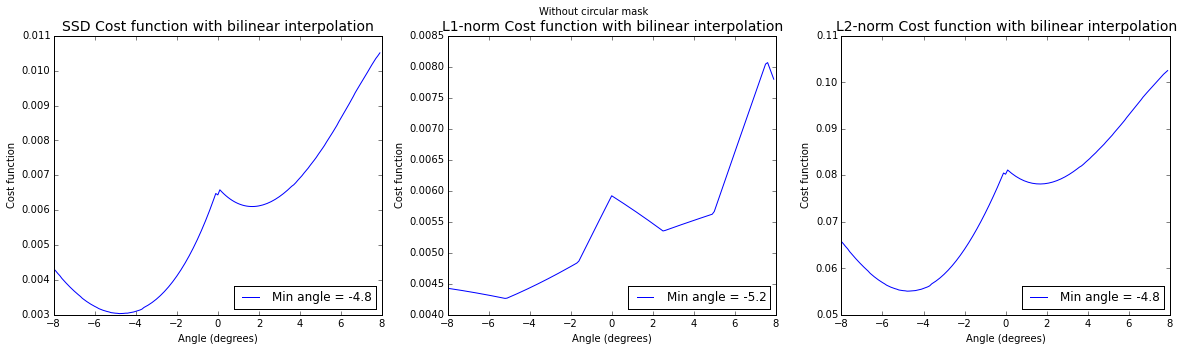

In [10]:
# Cost Function from Bilinear Interpolation
thetas=np.arange(-8,8,0.1)
# without circular mask
fig, ax = plt.subplots(1,3)
fig.set_figwidth(20)
fig.set_figheight(5)
fig.suptitle("Without circular mask")
rot_cost_func(vol1, vol2, thetas, cf_ssd, 'SSD',ax[0])
rot_cost_func(vol1, vol2, thetas, cf_L1, 'L1-norm',ax[1])
rot_cost_func(vol1, vol2, thetas, cf_L2, 'L2-norm',ax[2])
plt.show()
plt.close(fig)

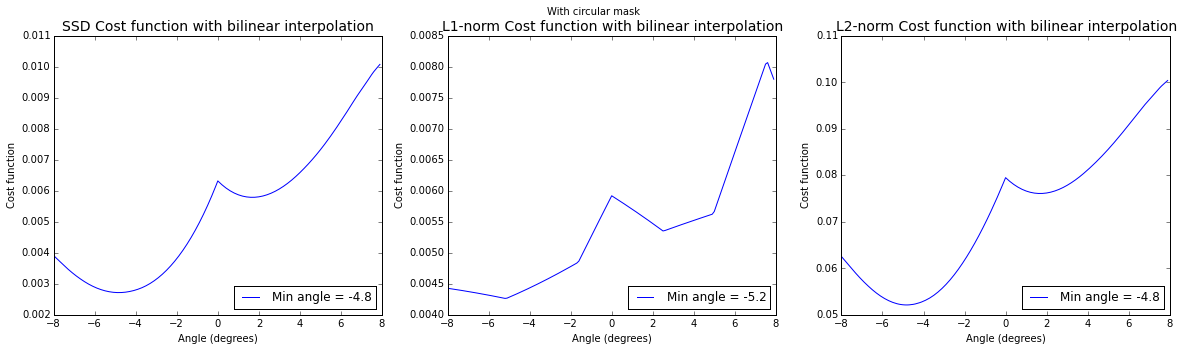

In [11]:
# Cost Function from Bilinear Interpolation
# with circular mask
thetas=np.arange(-8,8,0.1)
fig, ax = plt.subplots(1,3)
fig.set_figwidth(20)
fig.set_figheight(5)
fig.suptitle("With circular mask")
rot_cost_func(vol1, vol2, thetas, cf_ssd, 'SSD',ax[0],mask=True)
rot_cost_func(vol1, vol2, thetas, cf_L1, 'L1-norm',ax[1],mask=True)
rot_cost_func(vol1, vol2, thetas, cf_L2, 'L2-norm',ax[2],mask=True)
plt.show()
plt.close(fig)

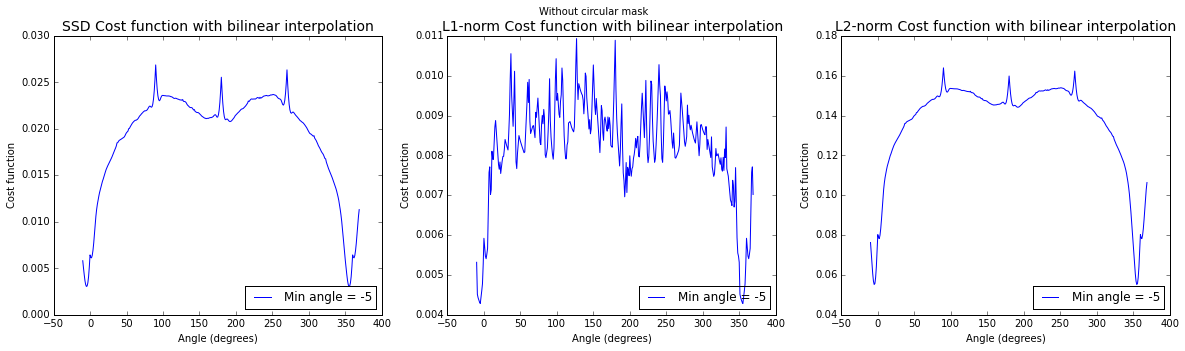

In [69]:
# Cost Function from Bilinear Interpolation for a wider range
# without mask

thetas=np.arange(-10,370,1)
fig, ax = plt.subplots(1,3)
fig.set_figwidth(20)
fig.set_figheight(5)
fig.suptitle("Without circular mask")
rot_cost_func(vol1, vol2, thetas, cf_ssd, 'SSD',ax[0])
rot_cost_func(vol1, vol2, thetas, cf_L1, 'L1-norm',ax[1])
rot_cost_func(vol1, vol2, thetas, cf_L2, 'L2-norm',ax[2])
plt.show()
plt.close(fig)

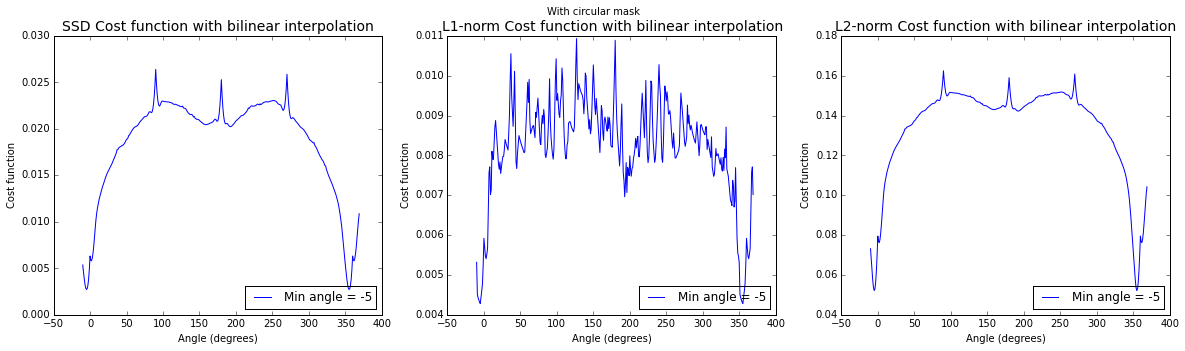

In [70]:
# Cost Function from Bilinear Interpolation for a wider range
# with mask
thetas=np.arange(-10,370,1)
fig, ax = plt.subplots(1,3)
fig.set_figwidth(20)
fig.set_figheight(5)
fig.suptitle("With circular mask")
rot_cost_func(vol1, vol2, thetas, cf_ssd, 'SSD',ax[0],mask=True)
rot_cost_func(vol1, vol2, thetas, cf_L1, 'L1-norm',ax[1],mask=True)
rot_cost_func(vol1, vol2, thetas, cf_L2, 'L2-norm',ax[2],mask=True)
plt.show()
plt.close(fig)

## Use Halton Sampling to Evaluate Cost Function 

In [86]:
def Halton_cost_func(N, vol1, vol2, thetas, cf, arg, interpolation = 'bilinear',mask=False):
    '''
    N: Number of points for Halton Sampling
    vol1: original image
    vol2: volume to be rotated
    thetas: list of degress to try
    cf: cost function
    arg: string for plot titles
    '''
    t0 = time.time()
    # generate Halton Sequence in the 32*32*32 grid
    sequencer = ghalton.GeneralizedHalton(ghalton.EA_PERMS[:3])
    sequencer.reset()
    points = sequencer.get(N)
    pts = np.array(points)
    x1 = 31 * pts[:,0]
    y1 = 31 * pts[:,1]
    
    new_vol1 = np.empty([vol1.shape[0],N,N])
    cost_func = np.zeros(len(thetas))
    for idx, t in enumerate(thetas):
        new_vol2 = np.empty([vol2.shape[0],N,N])
        for i in xrange(32):
            if(mask):
                vol1[i,:,:] = circle_mask(vol1[i,:,:])
            sub = vol2[i,:,:]
            rot = imrotate(sub, t, interpolation, mask)
            new_vol2[i,:,:] = bilinear_interp(rot, x1, y1)
            sub1 = vol1[i,:,:]
            new_vol1[i,:,:] = bilinear_interp(sub1, x1, y1)
        cost_func[idx] = cf(new_vol2,new_vol1)
    t1 = time.time()
    print 'Time for %s halton samples is %s seconds' % (N,t1-t0)
    
    angMin = thetas[np.argmin(cost_func)]
    plt.plot(thetas,cost_func,label='Min angle = %s' % (angMin))
    plt.title('%s Cost function with %s interpolation' % (arg,interpolation), fontsize=14)
    plt.xlabel('Angle (degrees)')
    plt.ylabel('Cost function')
    plt.legend(loc=4)

Time for 100 halton samples is 2.94168710709 seconds


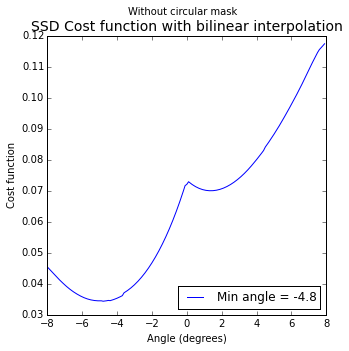

In [88]:
# Cost Function from Bilinear Interpolation with Halton Sampling
N = 100
thetas=np.arange(-8,8,0.1)
# without circular mask
fig, ax = plt.subplots(1,1)
fig.set_figwidth(5)
fig.set_figheight(5)
fig.suptitle("Without circular mask")
Halton_cost_func(N, vol1, vol2, thetas, cf_ssd, 'SSD')
plt.show()
plt.close(fig)

Time for 1000 halton samples is 80.7022922039 seconds


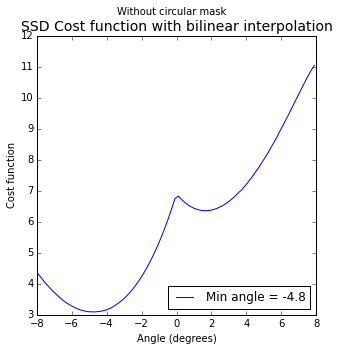

In [87]:
# Cost Function from Bilinear Interpolation with Halton Sampling
N = 1000
thetas=np.arange(-8,8,0.1)
# without circular mask
fig, ax = plt.subplots(1,1)
fig.set_figwidth(5)
fig.set_figheight(5)
fig.suptitle("Without circular mask")
Halton_cost_func(N, vol1, vol2, thetas, cf_ssd, 'SSD')
plt.show()
plt.close(fig)